In [87]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Model
from sklearn.metrics import confusion_matrix
from abc import ABC, abstractmethod
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import Callback

### Create DataSet Classes

In [88]:
class LoadDataSet(ABC):
    @abstractmethod
    def load_data(self):
        pass
    
class NormalizeDataSet(ABC):
    @abstractmethod
    def normalize_data(self):
        pass
    
class EncodeDataSet(ABC):
    @abstractmethod
    def encode_data(self):
        pass
    
    

In [89]:
# Load the CIFAR-10 dataset using Keras
class CifarTenLoader(LoadDataSet):
    def load_data(self):
        return cifar10.load_data()

# Normalize the pixel values to the range [0, 1].
class CifarTenNormalize(NormalizeDataSet):
    def normalize_data(self,data:np.ndarray):
        return data.reshape((data.shape[0], 32, 32, 3)).astype('float32') / 255

# One-hot encode the labels. 
class CifarTenEncode(EncodeDataSet):
    def encode_data(self,labels):
        return to_categorical(labels)

In [90]:
# Load and Preprocess the Data 
class CifarTenDataset:
    def __init__(self,data_loader:LoadDataSet,data_normalize:NormalizeDataSet,data_encode:EncodeDataSet):
        self.data_loader = data_loader
        self.data_normalize = data_normalize
        self.data_encode = data_encode
        self.train_images = None
        self.test_images = None
        self.train_labels = None
        self.test_labels = None
        
    def load_and_preprocess_data(self):
        (self.train_images, self.train_labels), (self.test_images, self.test_labels) = self.data_loader.load_data()
        self.train_images=self.data_normalize.normalize_data(self.train_images)
        self.test_images=self.data_normalize.normalize_data(self.test_images)
        self.train_labels=self.data_encode.encode_data(self.train_labels)
        self.test_labels=self.data_encode.encode_data(self.test_labels)
        return self.train_images, self.train_labels, self.test_images, self.test_labels

### Load and Preprocess the Data

In [91]:
data_loader=CifarTenLoader()
normalize_data=CifarTenNormalize()
encode_data=CifarTenEncode()

In [92]:
preprocess_data=CifarTenDataset(data_loader,normalize_data,encode_data)
train_images, train_labels, test_images, test_labels=preprocess_data.load_and_preprocess_data()

### Visualization The Data

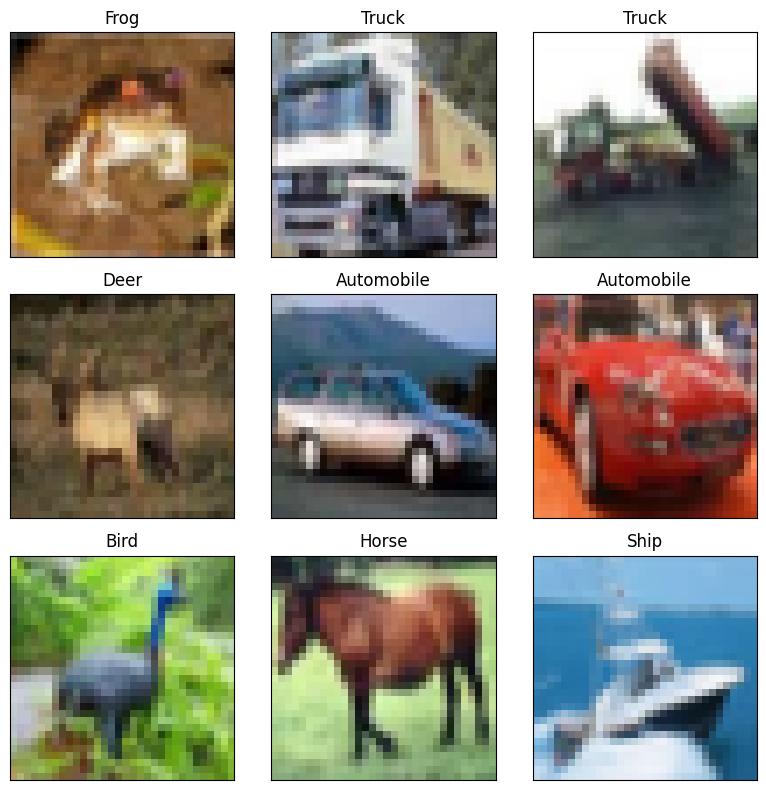

In [93]:
(images, labels), _ = data_loader.load_data()
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 
               'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

fig, axes = plt.subplots(3, 3, figsize=(8, 8))

# Loop through images and plot
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i])  # No cmap needed for RGB images
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(class_names[int(labels[i][0])])  # Fix label placement

# Adjust layout to fix spacing issues
plt.tight_layout()
plt.show()

### Create Model Classes

In [94]:
class BuildModel(ABC):
    @abstractmethod
    def build_model(self):
        pass

class TrainModel(ABC):
    @abstractmethod
    def train_model(self,model):
        pass

class EvaluateModel(ABC):
    @abstractmethod
    def evaluate_model(self,model):
        pass

In [95]:
from dataclasses import dataclass

@dataclass
class BuilderConfiguration:
    layers:list[layers.Layer]
    optimizer:str
    loss:str
    metrics:list[str]

@dataclass
class TrainConfiguration:
    train_data:np.ndarray
    train_labels:np.ndarray
    epochs:int
    batch_size:int
    validation_split:float
    callbacks:list[Callback]
    
@dataclass
class EvaluationConfiguration:
    test_data:np.ndarray
    test_labels:np.ndarray
    

In [96]:
class CNNBuilder(BuildModel):
    def __init__(self,configuration:BuilderConfiguration):
        self.configuration = configuration
    
    def build_model(self):
        model = models.Sequential(self.configuration.layers)
        model.compile(optimizer=self.configuration.optimizer,
                      loss=self.configuration.loss,metrics=self.configuration.metrics)
        
        return model

class CNNTrain(TrainModel):
    def __init__(self,configuration:TrainConfiguration):
        self.configuration = configuration
    
    def train_model(self,model):
        history = model.fit(self.configuration.train_data,self.configuration.train_labels
                                               ,epochs=self.configuration.epochs,batch_size=self.configuration.batch_size
                                               ,validation_split=self.configuration.validation_split
                                               ,callbacks=self.configuration.callbacks)
        return history

class CNNEvaluate(EvaluateModel):
    def __init__(self,configuration:EvaluationConfiguration):
        self.configuration = configuration
    
    def evaluate_model(self,model):
        test_loss, test_acc=model.evaluate(self.configuration.test_data,self.configuration.test_labels)
        return test_loss, test_acc

In [97]:
class CNNPipeline:
    def __init__(self,builder:CNNBuilder,train:CNNTrain,evaluate:CNNEvaluate):
        self.builder = builder
        self.train = train
        self.evaluate = evaluate
        self.model = None
        self.history = None
        self.test_loss = None
        self.test_acc = None
    
    def pipeline(self):
        if not self.builder.configuration:
            raise ValueError('Model configuration cannot be empty')
        if not self.train.configuration:
            raise ValueError('Training configuration cannot be empty')
        if not self.evaluate.configuration:
            raise ValueError('Evaluation configuration cannot be empty')
        
        self.model = self.builder.build_model()
        self.history = self.train.train_model(model=self.model)
        self.test_loss,self.test_acc = self.evaluate.evaluate_model(model=self.model)
        return self.model, self.history, self.test_loss, self.test_acc

### Create plot classes

In [98]:
class Visualization(ABC):
    @abstractmethod
    def visualize(self):
        pass


In [99]:
class TrainValidationAccuracy(Visualization):
    def __init__(self,history):
        self.history = history

    def visualize(self):
        plt.plot(self.history.history['accuracy'], label='Training Accuracy')
        plt.plot(self.history.history['val_accuracy'], label='Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()

class TrainValidationLoss(Visualization):
    def __init__(self,history):
        self.history = history
    
    def visualize(self):
        plt.plot(self.history.history['loss'], label='Training Loss')
        plt.plot(self.history.history['val_loss'], label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

In [100]:
def learning_rate_scheduler(epoch):
    initial_lr=0.001
    decay_factor=0.1
    decay_epochs=5
    lr = initial_lr * (decay_factor ** (epoch // decay_epochs))
    return lr

lr_scheduler=LearningRateScheduler(learning_rate_scheduler)
early_stopping=EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

### Build a CNN Model

In [101]:
build_config=BuilderConfiguration(layers=[
    layers.Conv2D(32, (3, 3), activation='relu',input_shape=(32, 32, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
],
    optimizer="adam",loss='categorical_crossentropy',metrics=['accuracy']
)

train_config=TrainConfiguration(train_data=train_images,train_labels=train_labels,epochs=10,batch_size=32,
                                validation_split=0.2,callbacks=[lr_scheduler,early_stopping])

evaluate_config=EvaluationConfiguration(test_data=test_images,test_labels=test_labels)

In [102]:
builder=CNNBuilder(build_config)
train=CNNTrain(train_config)
evaluation=CNNEvaluate(evaluate_config)

pipeline=CNNPipeline(builder,train,evaluation)
model, history, test_loss, test_acc=pipeline.pipeline()
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.3470 - loss: 1.7799 - val_accuracy: 0.5282 - val_loss: 1.3199 - learning_rate: 0.0010
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.5669 - loss: 1.2167 - val_accuracy: 0.6100 - val_loss: 1.1120 - learning_rate: 0.0010
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.6327 - loss: 1.0389 - val_accuracy: 0.6349 - val_loss: 1.0745 - learning_rate: 0.0010
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.6802 - loss: 0.9161 - val_accuracy: 0.6443 - val_loss: 1.0243 - learning_rate: 0.0010
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.7046 - loss: 0.8467 - val_accuracy: 0.6587 - val_loss: 1.0036 - learning_rate: 0.0010
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.7565 - loss: 0.7079 - val_accuracy: 0.6959 - val_loss: 0.8955 - learning_rate: 1.0000e-04
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.7689

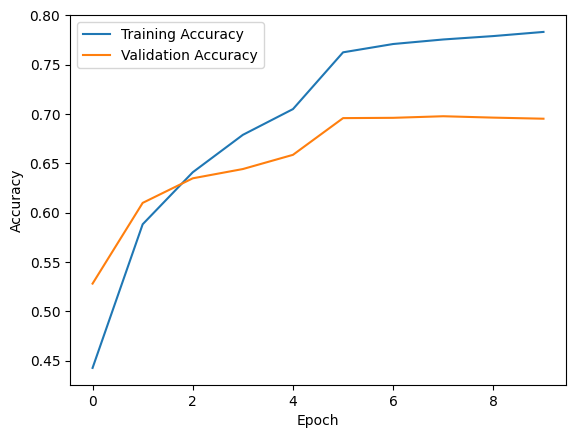

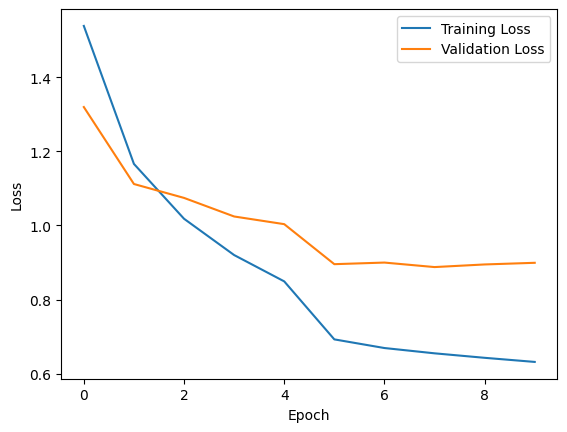

In [103]:
train_validation_accuracy=TrainValidationAccuracy(history)
train_validation_loss=TrainValidationLoss(history)
train_validation_accuracy.visualize()
train_validation_loss.visualize()

### Add dropout layers to reduce overfitting.

In [104]:
build_config=BuilderConfiguration(layers=[
    layers.Conv2D(32, (3, 3), activation='relu',input_shape=(32, 32, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.5),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.5),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
],
    optimizer="adam",loss='categorical_crossentropy',metrics=['accuracy']
)

train_config=TrainConfiguration(train_data=train_images,train_labels=train_labels,epochs=20,batch_size=16,
                                validation_split=0.2,callbacks=[lr_scheduler,early_stopping])

evaluate_config=EvaluationConfiguration(test_data=test_images,test_labels=test_labels)

In [105]:
builder=CNNBuilder(build_config)
train=CNNTrain(train_config)
evaluation=CNNEvaluate(evaluate_config)

pipeline=CNNPipeline(builder,train,evaluation)
model, history, test_loss, test_acc=pipeline.pipeline()
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

Epoch 1/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.3334 - loss: 1.8134 - val_accuracy: 0.5318 - val_loss: 1.3533 - learning_rate: 0.0010
Epoch 2/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.5117 - loss: 1.3636 - val_accuracy: 0.5867 - val_loss: 1.2368 - learning_rate: 0.0010
Epoch 3/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.5481 - loss: 1.2730 - val_accuracy: 0.6073 - val_loss: 1.1966 - learning_rate: 0.0010
Epoch 4/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.5694 - loss: 1.2047 - val_accuracy: 0.5906 - val_loss: 1.1699 - learning_rate: 0.0010
Epoch 5/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.5872 - loss: 1.1607 - val_accuracy: 0.6272 - val_loss: 1.1054 - learning_rate: 0.0010
Epoch 6/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.6218 - loss: 1.0650 - val_accuracy: 0.6509 - val_loss: 1.0219 - learning_rate: 1.0000e-04
Epoch 7/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy:

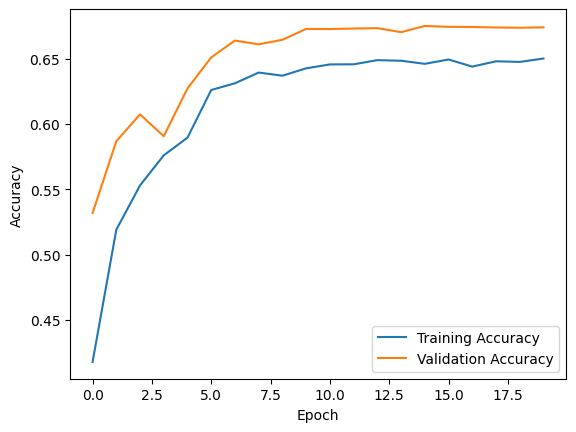

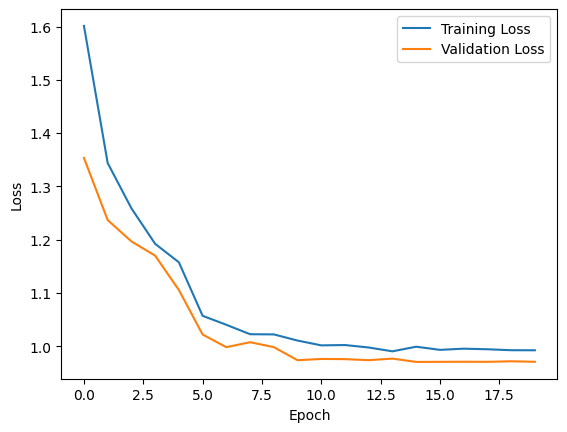

In [106]:
train_validation_accuracy=TrainValidationAccuracy(history)
train_validation_loss=TrainValidationLoss(history)
train_validation_accuracy.visualize()
train_validation_loss.visualize()

### Increase the depth (number of conv layers) or width (number of filters) of the model. 

In [107]:
build_config=BuilderConfiguration(layers=[
    layers.Conv2D(32, (3, 3), activation='relu',input_shape=(32, 32, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
],
    optimizer="adam",loss='categorical_crossentropy',metrics=['accuracy']
)

train_config=TrainConfiguration(train_data=train_images,train_labels=train_labels,epochs=10,batch_size=32,
                                validation_split=0.2,callbacks=[lr_scheduler,early_stopping])

evaluate_config=EvaluationConfiguration(test_data=test_images,test_labels=test_labels)

In [108]:
builder=CNNBuilder(build_config)
train=CNNTrain(train_config)
evaluation=CNNEvaluate(evaluate_config)

pipeline=CNNPipeline(builder,train,evaluation)
model, history, test_loss, test_acc=pipeline.pipeline()
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.3205 - loss: 1.8271 - val_accuracy: 0.5009 - val_loss: 1.3793 - learning_rate: 0.0010
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.5546 - loss: 1.2525 - val_accuracy: 0.5997 - val_loss: 1.1450 - learning_rate: 0.0010
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.6223 - loss: 1.0632 - val_accuracy: 0.6405 - val_loss: 1.0354 - learning_rate: 0.0010
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.6717 - loss: 0.9399 - val_accuracy: 0.6630 - val_loss: 0.9707 - learning_rate: 0.0010
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.6999 - loss: 0.8621 - val_accuracy: 0.6627 - val_loss: 0.9764 - learning_rate: 0.0010
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.7601 - loss: 0.6988 - val_accuracy: 0.7083 - val_loss: 0.8667 - learning_rate: 1.0000e-04
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.7766

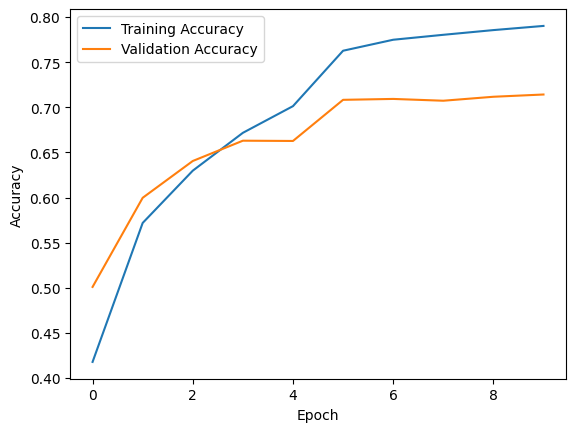

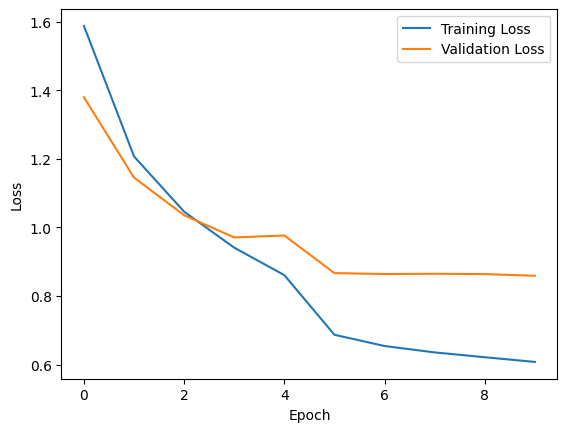

In [109]:
train_validation_accuracy=TrainValidationAccuracy(history)
train_validation_loss=TrainValidationLoss(history)
train_validation_accuracy.visualize()
train_validation_loss.visualize()

### Use data augmentation to increase the diversity of the training data.

### Use adamw optimizer

In [111]:
build_config=BuilderConfiguration(layers=[
    layers.Conv2D(32, (3, 3), activation='relu',input_shape=(32, 32, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
],
    optimizer="adamw",loss='categorical_crossentropy',metrics=['accuracy']
)

train_config=TrainConfiguration(train_data=train_images,train_labels=train_labels,epochs=10,batch_size=32,
                                validation_split=0.2,callbacks=[lr_scheduler,early_stopping])

evaluate_config=EvaluationConfiguration(test_data=test_images,test_labels=test_labels)

In [112]:
builder=CNNBuilder(build_config)
train=CNNTrain(train_config)
evaluation=CNNEvaluate(evaluate_config)

pipeline=CNNPipeline(builder,train,evaluation)
model, history, test_loss, test_acc=pipeline.pipeline()
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.3433 - loss: 1.7812 - val_accuracy: 0.5407 - val_loss: 1.2910 - learning_rate: 0.0010
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.5615 - loss: 1.2271 - val_accuracy: 0.5959 - val_loss: 1.1514 - learning_rate: 0.0010
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - accuracy: 0.6258 - loss: 1.0724 - val_accuracy: 0.6291 - val_loss: 1.0650 - learning_rate: 0.0010
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.6569 - loss: 0.9738 - val_accuracy: 0.6428 - val_loss: 1.0238 - learning_rate: 0.0010
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.6878 - loss: 0.9131 - val_accuracy: 0.6344 - val_loss: 1.0440 - learning_rate: 0.0010
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.7254 - loss: 0.7928 - val_accuracy: 0.6807 - val_loss: 0.9395 - learning_rate: 1.0000e-04
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy

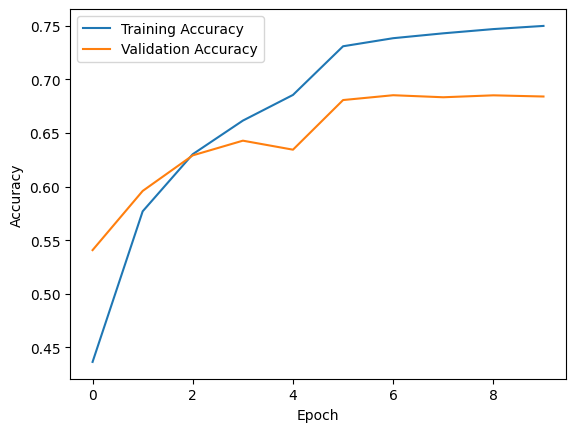

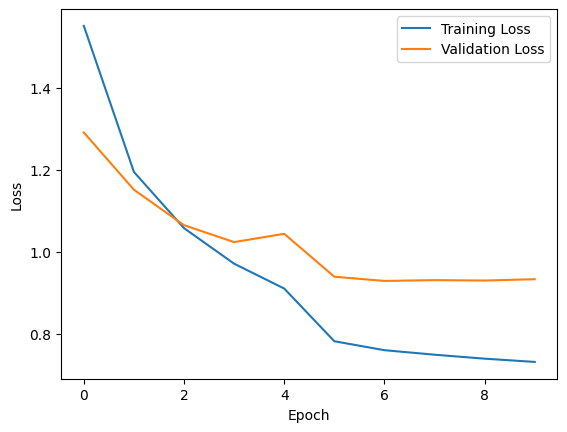

In [113]:
train_validation_accuracy=TrainValidationAccuracy(history)
train_validation_loss=TrainValidationLoss(history)
train_validation_accuracy.visualize()
train_validation_loss.visualize()

### Add batch normalization layers to stabilize training. 

In [114]:
build_config=BuilderConfiguration(layers=[
    layers.Conv2D(32, (3, 3), activation='relu',input_shape=(32, 32, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(10, activation='softmax')
],
    optimizer="adam",loss='categorical_crossentropy',metrics=['accuracy']
)

train_config=TrainConfiguration(train_data=train_images,train_labels=train_labels,epochs=10,batch_size=32,
                                validation_split=0.2,callbacks=[lr_scheduler,early_stopping])

evaluate_config=EvaluationConfiguration(test_data=test_images,test_labels=test_labels)

In [115]:
builder=CNNBuilder(build_config)
train=CNNTrain(train_config)
evaluation=CNNEvaluate(evaluate_config)

pipeline=CNNPipeline(builder,train,evaluation)
model, history, test_loss, test_acc=pipeline.pipeline()
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.4603 - loss: 1.5183 - val_accuracy: 0.5053 - val_loss: 1.4130 - learning_rate: 0.0010
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.6350 - loss: 1.0665 - val_accuracy: 0.5859 - val_loss: 1.2116 - learning_rate: 0.0010
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.6699 - loss: 0.9558 - val_accuracy: 0.6649 - val_loss: 0.9803 - learning_rate: 0.0010
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.7023 - loss: 0.8577 - val_accuracy: 0.6769 - val_loss: 0.9600 - learning_rate: 0.0010
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.7199 - loss: 0.7981 - val_accuracy: 0.6967 - val_loss: 0.8891 - learning_rate: 0.0010
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.7804 - loss: 0.6544 - val_accuracy: 0.7115 - val_loss: 0.8506 - learning_rate: 1.0000e-04
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.7948

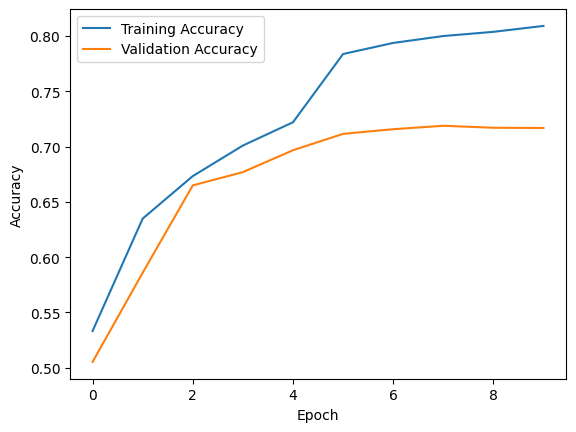

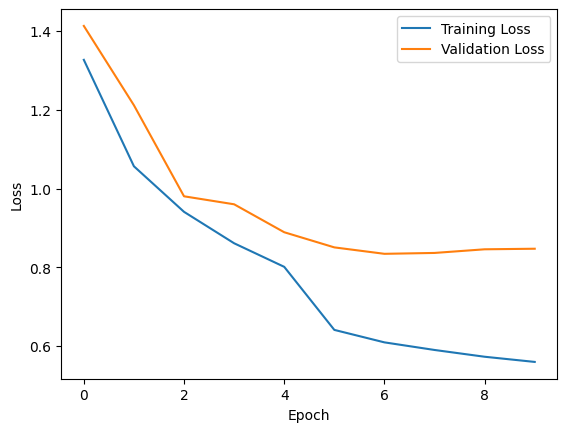

In [116]:
train_validation_accuracy=TrainValidationAccuracy(history)
train_validation_loss=TrainValidationLoss(history)
train_validation_accuracy.visualize()
train_validation_loss.visualize()